# **Classify Stock Price Trends**
In this assignment, I'll try to see if we can see strong trends on stock price per industry.  
Some event will strongly affect to certain kind of business. So sometimes we should be able to see similar trends on similar company.  
So we may see that clustering algorithm will have clear separation for each category where each company sits in.

At the same time, stock price are correlated with performance of each company and should be different even if they are in the same category.  
Let's see how it works.

## **Description**
### Stock Price Dataset
Data is downloaded from [Here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data).  
Only relevant directory ("Stocks") is used as the dataset also contain ETF (Exchange Traded Fund) information which is out of scope for this project.

Assume directory "Stocks" is downloaded directly under D drive. (I don't upload data itself as data is a bit too heavy.)

### Ticker Symbol and Its Association to sector
Ticker symbol is an abrreviation character for the company on the stock market. Maybe you've seen and know that **'AAPL'** means **apple inc**.  
Stock Price Dataset we use are named using ticker symbol. So I need to know mapping between ticker symbol to some kind of category information.

There are several services to obtain such information like [here](https://sec-api.io/profile).  
This time, I pre-fetched data and stored to `ticekr_mapping.csv`, as it takes a bit long. 

***

## **Import libraries**

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
parent_dir = "D:/Stocks"

## Preload data
# SIC_detail = pd.read_csv("SIC_detail.csv")
ticker_mapping = pd.read_csv("ticker_mapping.csv")

## **Pre-fetched Data: Tcker Symbol and Sector Info**
Below is a example of my pre-fetched data. You can see that there is `ticker` column which can be used as key to other info.  
There are several columns to represent company's sector info. Here I saw a bit to see how is it like.

In [3]:
ticker_mapping.head()

,Unnamed: 0,name,ticker,cik,cusip,exchange,isDelisted,category,sector,industry,sic,sicSector,sicIndustry,famaSector,famaIndustry,currency,location,id
0,0,AGILENT TECHNOLOGIES INC,A,1090872.0,00846U101,NYSE,False,Domestic Common Stock,Healthcare,Diagnostics & Research,3826,Manufacturing,Laboratory Analytical Instruments,NaN,Measuring and Control Equipment,USD,California; U.S.A,81e134d27f5a89e6e88c39798d1497b0
1,1,ALCOA CORP,AA,1675149.0,13872106,NYSE,False,Domestic Common Stock,Basic Materials,Aluminum,3334,Manufacturing,Primary Production Of Aluminum,NaN,Steel Works Etc,USD,Pennsylvania; U.S.A,06b2234c0416841fec48880d3a0fa76d
2,2,ADVANCED ACCELERATOR APPLICATIONS SA,AAAP,1611787.0,00790T100,NASDAQ,True,ADR Common Stock,Healthcare,Biotechnology,2834,Manufacturing,Pharmaceutical Preparations,NaN,Pharmaceutical Products,EUR,France,cf1185a716b218ee7db7d812695108eb
3,3,ARES ACQUISITION CORP,AAC,1829432.0,G33032106,NYSE,False,Domestic Common Stock Primary Class,Industrials,Shell Companies,6770,Finance Insurance And Real Estate,Blank Checks,NaN,Trading,USD,New York; U.S.A,3fd560f6b81a7525affb90b150a56f5d
4,4,AMERICAN AIRLINES GROUP INC,AAL,6201.0,02376R102,NASDAQ,False,Domestic Common Stock,Industrials,Airlines,4512,Transportation Communications Electric Gas And...,Air Transportation Scheduled,NaN,Transportation,USD,Texas; U.S.A,2abec5e05ce206a98025c65fc1e5c645


### sicSector (not used)
All company on the stock market has dedicated category called SIC (Standard Industrial Classification) number to it.  
But as you can see, number of data on each sicSector has hugely biased.

In [4]:
ticker_mapping.groupby("sicSector").count()["sic"]

sicSector
Agriculture Forestry And Fishing                                     18
Construction                                                         44
Finance Insurance And Real Estate                                  1340
Manufacturing                                                      2020
Mining                                                              274
Nonclassifiable                                                       1
Retail Trade                                                        242
Services                                                            922
Transportation Communications Electric Gas And Sanitary Service     465
Wholesale Trade                                                     130
Name: sic, dtype: int64

### **sector** (**used**)
There are another column to explain company's sector.  
It seems the number of company for each category is well balanced  

Well balanced or not isn't necessary condition for analysis as "how properly categorized" is mroe important to see the relationship.  
But it would be better to choose well balanced data, to make analysis in limited timeslot.

In [5]:
ticker_mapping.groupby("sector").count()["sic"]

sector
Basic Materials            280
Communication Services     261
Consumer Cyclical          479
Consumer Defensive         213
Energy                     293
Financial Services         888
Healthcare                1021
Industrials                711
Real Estate                226
Technology                 883
Utilities                   84
Name: sic, dtype: int64

### Industry (not ised)
This is another example. But number of category is too much (151 categories!) and not appropriate for my purpose.

In [6]:
ticker_mapping.groupby("industry").count()["sic"]

industry
Advertising Agencies              30
Aerospace & Defense               43
Agricultural Inputs               14
Airlines                          20
Airports & Air Services           15
                                  ..
Utilities - Regulated Electric    30
Utilities - Regulated Gas          8
Utilities - Regulated Water       20
Utilities - Renewable              9
Waste Management                  28
Name: sic, Length: 151, dtype: int64

***
## **Exploratory Data Analysis**
As described below, dataset contains stock price information of 7195 companies.

In [7]:
files = glob.glob(parent_dir + "/*.us.txt")
print(len(files))

7195


### Data Collection Period
Some companies weren't exist in early days and some others went bankrupsy.  
Here I'd like to use limited period of time to simplify the problem. I want to know starting and ending date of records.

You can see that oldest data started to capture from 1962. And most of the data contains data until November of 2017.

In [8]:
start_end = []
for file in files:
    try:
        df = pd.read_csv(file)
        ### Do Some Stuff
    except:
        continue
        # or pass
    start_end.append({'path': file, 'start': df['Date'].iloc[0], 'end': df['Date'].iloc[-1]})

In [9]:
start_end_df = pd.DataFrame(start_end)
start_end_df['start'] = pd.to_datetime(start_end_df['start'], format='%Y-%m-%d')
start_end_df['end'] = pd.to_datetime(start_end_df['end'], format='%Y-%m-%d')
start_end_df.describe(datetime_is_numeric=True)

,start,end
count,7163,7163
mean,2009-05-29 14:28:15.714086400,2017-11-09 12:24:01.407231488
min,1962-01-02 00:00:00,2017-06-07 00:00:00
25%,2005-02-25 00:00:00,2017-11-10 00:00:00
50%,2010-08-23 00:00:00,2017-11-10 00:00:00
75%,2015-05-27 00:00:00,2017-11-10 00:00:00
max,2017-11-10 00:00:00,2017-11-10 00:00:00


## See with Histogram
We can see that many companies on this dataset were launched around 2005.

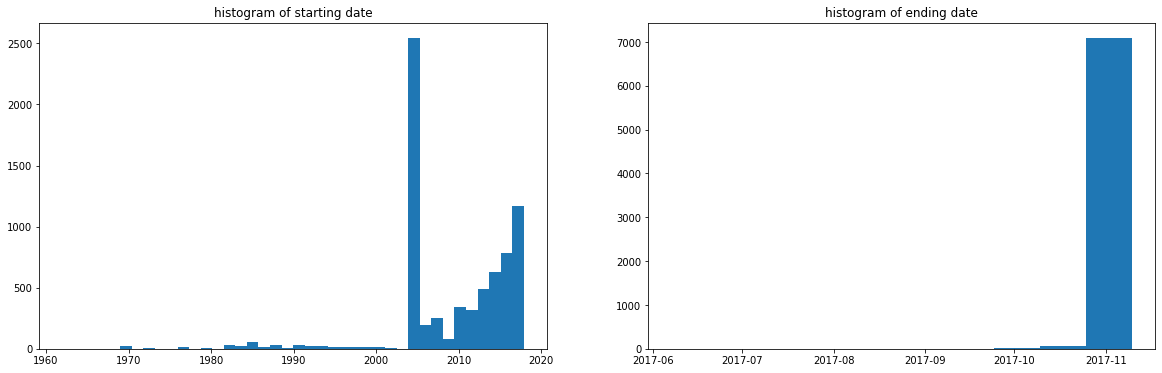

In [10]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(start_end_df['start'], bins=40)
ax1.set_title("histogram of starting date")
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(start_end_df['end'])
ax2.set_title("histogram of ending date")
plt.show()

## Cut Off the Data Which Doesn't Contain Stock Price Info Within Specified Period
After several iterations, I found that clustering using data with too long duration has too high varianced and becomes too dificult task.  
So I've decided to apply clustering algorithm against 1 year data.

In [11]:
# Here to specify the period to be analyzed
STARTING_DATE = '2016-01-01'
ENDING_DATE = '2016-12-31'

valid_df = start_end_df[start_end_df['start'] < datetime.strptime(STARTING_DATE, '%Y-%m-%d')]
valid_df = valid_df[start_end_df['end'] > datetime.strptime(ENDING_DATE, '%Y-%m-%d')]
valid_df.reset_index(drop=True)

<ipython-input-11-921ce855b395>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_df = valid_df[start_end_df['end'] > datetime.strptime(ENDING_DATE, '%Y-%m-%d')]


,path,start,end
0,D:/Stocks\a.us.txt,1999-11-18,2017-11-10
1,D:/Stocks\aa.us.txt,1970-01-02,2017-11-10
2,D:/Stocks\aaap.us.txt,2015-11-11,2017-11-10
3,D:/Stocks\aaba.us.txt,1996-04-12,2017-11-10
4,D:/Stocks\aac.us.txt,2014-10-02,2017-11-10
...,...,...,...
5746,D:/Stocks\ztr.us.txt,2005-02-25,2017-11-10
5747,D:/Stocks\zts.us.txt,2013-02-01,2017-11-10
5748,D:/Stocks\zumz.us.txt,2005-05-05,2017-11-10
5749,D:/Stocks\zx.us.txt,2011-05-16,2017-11-10


### Calculate Mean Price for Simplification
Data contains daily stock price information, but this needs to be simplified so that explanatory variables becomes simple enough for out application.

In [12]:
dataset_df = pd.DataFrame()
for idx, row in valid_df.iterrows():
    ticker_symbol = os.path.basename(row['path']).split('.')[0]
    df = pd.read_csv(row['path'])
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df= df[df['Date'] >= datetime.strptime(STARTING_DATE, '%Y-%m-%d')]
    df= df[df['Date'] <= datetime.strptime(ENDING_DATE, '%Y-%m-%d')]
    df = df.groupby(pd.Grouper(key="Date", freq="MS")).mean()
    if df.isnull().sum().sum() > 0:
        # data which contains null (maybe delisted for certain period)
        continue
    if dataset_df.empty:
        dataset_df = pd.DataFrame({ticker_symbol: df['Close']}, index=df.index.to_list())
    else:
        dataset_df[ticker_symbol] = df['Close']

### Remove data with invalid info
Some company has invalid data, and I decided to remove such data.

In [13]:
dataset_df = dataset_df.drop(dataset_df.T[dataset_df.isnull().sum() > 0].index, axis=1)

### Normalize with Min-Max Scaler
Stock prices have different scale. So I applied normalization so that we can see only entire trend.

You can see that dataframe has monthly average stock price for each company ticker symbols.

In [14]:
min_max_scaler = MinMaxScaler()
scaled_df = pd.DataFrame(min_max_scaler.fit_transform(dataset_df), columns=dataset_df.columns, index=dataset_df.index)

In [15]:
scaled_df.head()

,a,aa,aaap,aaba,aac,aal,aamc,aame,aan,aaoi,...,zn,znga,znh,zoes,zsan,ztr,zts,zumz,zx,zyne
2016-01-01,0.106095,0.000000,0.000000,0.063050,0.666455,0.534341,0.115305,0.851173,0.006297,0.335158,...,0.768048,0.411807,0.619087,0.336183,0.835856,0.142618,0.282814,0.193104,0.000000,0.277651
2016-02-01,0.000000,0.097357,0.117112,0.000000,0.865966,0.470213,0.110759,0.791926,0.000000,0.422466,...,0.926280,0.000000,0.129933,0.378367,0.807908,0.000000,0.000000,0.499043,0.064545,0.000000
2016-03-01,0.214134,0.346769,0.685483,0.361038,0.725390,0.647429,0.016805,0.650452,0.198027,0.492344,...,1.000000,0.175007,0.507063,1.000000,1.000000,0.390267,0.022146,0.553791,0.603471,0.413409
2016-04-01,0.361865,0.427966,0.729719,0.535883,0.800432,0.480696,0.127509,1.000000,0.421496,0.266700,...,0.831926,0.401325,0.829794,0.992685,0.784179,0.673471,0.556752,0.341022,0.586148,0.433265
2016-05-01,0.604899,0.345193,0.340443,0.545034,0.868356,0.132687,0.032894,0.252800,0.269407,0.000000,...,0.606923,0.559002,0.601850,0.946116,0.667220,0.628316,0.529556,0.021293,0.417009,0.137118


### Exmaple Output
Let's see example output using line plot. In 2016, it looks that stock price of IT companies were relatively steadily increased, but consumer products companies weren't.   

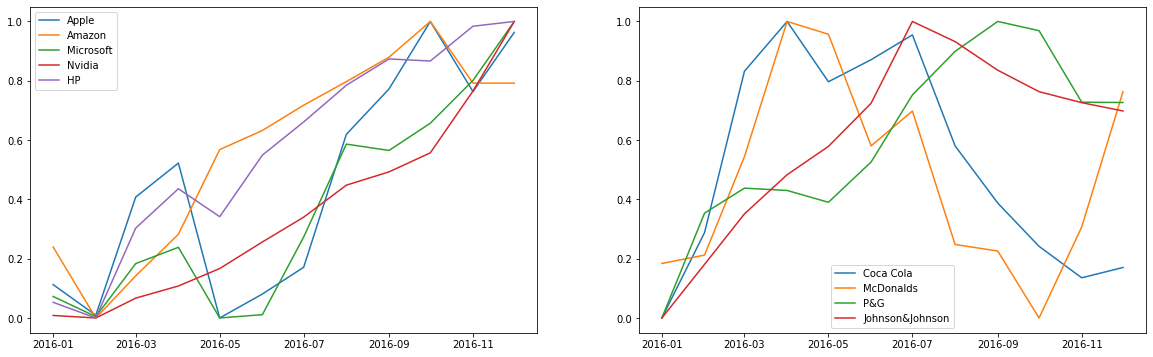

In [16]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(scaled_df['aapl'], label='Apple')
ax1.plot(scaled_df['amzn'], label='Amazon')
ax1.plot(scaled_df['msft'], label='Microsoft')
ax1.plot(scaled_df['nvda'], label='Nvidia')
ax1.plot(scaled_df['hpq'], label='HP')
ax1.legend()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(scaled_df['ko'], label='Coca Cola')
ax2.plot(scaled_df['mcd'], label='McDonalds')
ax2.plot(scaled_df['pg'], label='P&G')
ax2.plot(scaled_df['jnj'], label='Johnson&Johnson')
ax2.legend()

plt.show()

## Prepare Labels
Prepare labels so that we can join stock price data with company meta info.

In [17]:
mapping = []
ticker_mapping['ticker']
for symbol in dataset_df.columns.to_list():
    mapped = ticker_mapping[ticker_mapping['ticker'] == symbol.upper()]
    if mapped.empty:
        continue
    sicSector = mapped.iloc[0]['sicSector']
    sic = mapped.iloc[0]['sic']
    sector = mapped.iloc[0]['sector']
    mapping.append({'symbol': symbol, 'sic': sic, 'sicSector': sicSector, 'sector': sector})
mapping_df = pd.DataFrame(mapping)
mapping_df = mapping_df.set_index('symbol')

In [18]:
mapping_df.groupby("sector").count()["sic"]

sector
Basic Materials           176
Communication Services    146
Consumer Cyclical         293
Consumer Defensive        128
Energy                    165
Financial Services        575
Healthcare                551
Industrials               385
Real Estate               160
Technology                465
Utilities                  54
Name: sic, dtype: int64

### Exmaple Output
As you can see, tech companies has its sector info. Amazon is not treated as technology company. This makes sense for non-programmer guys, but it would affects to our analysis.

In [19]:
examples = ['aapl', 'amzn', 'msft', 'nvda', 'hpq']
pd.DataFrame([mapping_df[mapping_df.index == example].to_dict() for example in examples])

,sic,sicSector,sector
0,{'aapl': 3571},{'aapl': 'Manufacturing'},{'aapl': 'Technology'}
1,{'amzn': 5961},{'amzn': 'Retail Trade'},{'amzn': 'Consumer Cyclical'}
2,{'msft': 7372},{'msft': 'Services'},{'msft': 'Technology'}
3,{'nvda': 3674},{'nvda': 'Manufacturing'},{'nvda': 'Technology'}
4,{'hpq': 3570},{'hpq': 'Manufacturing'},{'hpq': 'Technology'}


## Some Filter to Join Stock Price with Meta Info
To make analysis easier, I need to limint the number of categories used for classification.

In [20]:
data = scaled_df.copy()
maps = mapping_df.copy()
counts = maps.groupby("sector").count()["sic"]
data_to_be_used = counts[counts >= 300].index.tolist()
                 
for col in data.columns:
    if col not in mapping_df.index:
        data = data.drop(col, axis=1)
        continue
    if maps[maps.index == col]['sector'].values[0] not in data_to_be_used:
        data = data.drop(col, axis=1)
        maps = maps.drop(col, axis=0)
        continue
data.head()

,a,aaap,aac,aal,aamc,aame,aan,aaoi,aapl,aaww,...,zayo,zbh,zbra,zgnx,zion,zionw,zionz,zixi,zts,zyne
2016-01-01,0.106095,0.000000,0.666455,0.534341,0.115305,0.851173,0.006297,0.335158,0.112566,0.000000,...,0.151121,0.164576,0.251711,0.572995,0.079539,0.045365,0.031721,0.898165,0.282814,0.277651
2016-02-01,0.000000,0.117112,0.865966,0.470213,0.110759,0.791926,0.000000,0.422466,0.009234,0.021737,...,0.000000,0.000000,0.339903,0.264274,0.000000,0.000000,0.000000,0.289014,0.000000,0.000000
2016-03-01,0.214134,0.685483,0.725390,0.647429,0.016805,0.650452,0.198027,0.492344,0.407840,0.271016,...,0.065584,0.223002,0.481666,0.264834,0.143581,0.057045,0.036145,0.175443,0.022146,0.413409
2016-04-01,0.361865,0.729719,0.800432,0.480696,0.127509,1.000000,0.421496,0.266700,0.522302,0.281016,...,0.149498,0.498084,0.441936,0.533087,0.199135,0.088294,0.073572,0.121838,0.556752,0.433265
2016-05-01,0.604899,0.340443,0.868356,0.132687,0.032894,0.252800,0.269407,0.000000,0.000000,0.512340,...,0.357807,0.672326,0.126474,0.275532,0.259273,0.098127,0.084335,0.041174,0.529556,0.137118


***
## **Apply t-SNE for Initial Investigation**
I applied t-SEN to see how clustering algorithm works. And it seems that clustering is not easy. (But I'll go with it...)  
Anyway, it looks Financial Services (green) has apparent cluster compared with others.

In [21]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 10, n_iter = 1000)

embedded = pd.DataFrame(tsne.fit_transform(data.T), columns=['x', 'y'], index=data.columns)
maps['sector'].unique()

array(['Healthcare', 'Industrials', 'Financial Services', 'Technology'],
      dtype=object)

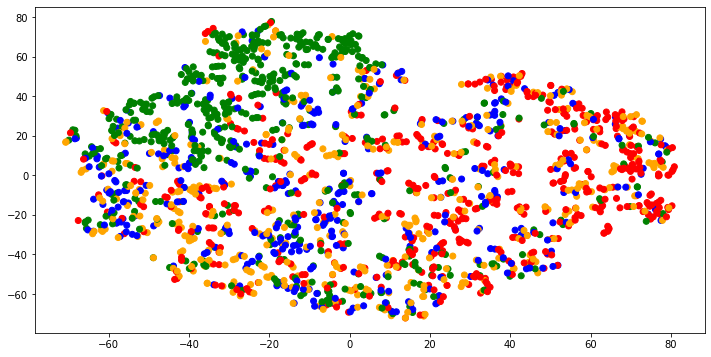

In [22]:
colors = {'Healthcare':'red',
          'Industrials':'blue',
          'Financial Services':'green',
          'Technology':'orange'
         }
embedded['sector'] = maps['sector']

fig = plt.figure(figsize=(12, 6))
plt.scatter(embedded['x'], embedded['y'], c=embedded['sector'].map(colors))
plt.show()

***
## **Apply Several Learning Approach**
### 1. Aggoromerative Clustering
Here I used Aggromerative Clustering implemented in sklearn compared with various parameters.

As we can see, "affinity=euclidean", "linkage: ward" achieved the best score.

In [23]:
import collections
import itertools

In [24]:
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    max_score = -1
    max_perm = -1
    arr = list(range(n))
    uniquelabels = ytdf.unique()
    for perm in itertools.permutations(arr):
        tmp_label = ytdf.copy()
        for i, p in enumerate(perm):
            tmp_label = tmp_label.replace({uniquelabels[i]: p})
        tmp_score = accuracy_score(tmp_label, yp)
        if tmp_score > max_score:
            max_perm = perm
            max_score = tmp_score
    return max_perm, max_score

In [25]:
for affinity in ['cityblock', 'euclidean','l1','l2','manhattan','cosine']:
    for linkage in ['ward', 'complete', 'average', 'single']:
        if linkage == 'ward' and affinity != 'euclidean':
            continue
        # build a model using n_clusters=5 option
        model=AgglomerativeClustering(n_clusters=4, affinity=affinity, linkage=linkage)
        # your code here
        model.fit(data.T)
        labelorder, acc = label_permute_compare(maps['sector'], model.labels_, 4)
        print(affinity, linkage, labelorder, acc)
        print(collections.Counter(model.labels_))

cityblock complete (0, 1, 3, 2) 0.4089068825910931
Counter({3: 918, 1: 532, 0: 408, 2: 118})
cityblock average (1, 2, 0, 3) 0.4018218623481781
Counter({0: 1413, 1: 429, 3: 72, 2: 62})
cityblock single (1, 2, 0, 3) 0.29200404858299595
Counter({0: 1973, 2: 1, 3: 1, 1: 1})
euclidean ward (0, 2, 1, 3) 0.409919028340081
Counter({1: 799, 2: 624, 0: 427, 3: 126})
euclidean complete (3, 0, 2, 1) 0.35728744939271256
Counter({2: 1267, 0: 316, 3: 220, 1: 173})
euclidean average (0, 1, 2, 3) 0.4033400809716599
Counter({2: 1400, 0: 454, 1: 77, 3: 45})
euclidean single (1, 2, 0, 3) 0.2909919028340081
Counter({0: 1973, 2: 1, 3: 1, 1: 1})
l1 complete (0, 1, 3, 2) 0.4089068825910931
Counter({3: 918, 1: 532, 0: 408, 2: 118})
l1 average (1, 2, 0, 3) 0.4018218623481781
Counter({0: 1413, 1: 429, 3: 72, 2: 62})
l1 single (1, 2, 0, 3) 0.29200404858299595
Counter({0: 1973, 2: 1, 3: 1, 1: 1})
l2 complete (3, 0, 2, 1) 0.35728744939271256
Counter({2: 1267, 0: 316, 3: 220, 1: 173})
l2 average (0, 1, 2, 3) 0.40334

### 2. K-means
I also used K-means algorithm for comparison.

And as you can see below, performance was more or less the same.

In [26]:
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit_predict(data.T)
labelorder, acc = label_permute_compare(maps['sector'], pred, 4)
print(labelorder, acc)

(0, 2, 1, 3) 0.3977732793522267


***
## **See Confusion Matrix**
As in the first visualization, "Financial Services" is clearer than others.

This is also reflected in the confusion matrix. It seems that "Healthcare" comes secondly clear.
"Industrials" and "Technology" are not so good (it seems performanceof "Technology" was sacrified for overall performance.)

In [27]:
# display confusion matrix here 
# your code here
model = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
model.fit(data.T)

tmp_label = maps['sector'].copy()
uniquelabels = maps['sector'].unique()
for i, p in enumerate((0, 2, 1, 3)):
    tmp_label = tmp_label.replace({uniquelabels[i]: p})
cm = confusion_matrix(tmp_label, model.labels_)

Text(32.99999999999999, 0.5, 'True')

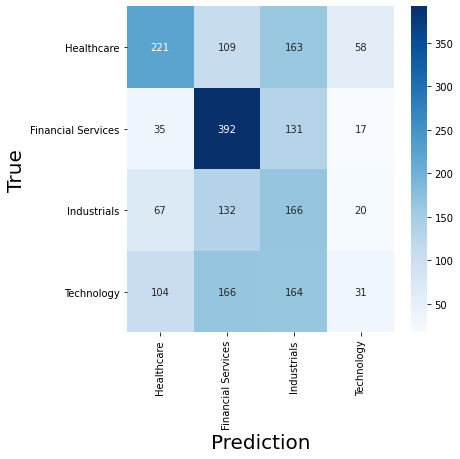

In [28]:
cm_label = []
for i, p in enumerate((0, 2, 1, 3)):
    cm_label.append(uniquelabels[p])
df_cm = pd.DataFrame(cm, index=cm_label, columns=cm_label)
plt.figure(figsize=(6, 6))
p=sns.heatmap(df_cm, annot=True, fmt=',.0f', cmap="Blues");
p.set_xlabel("Prediction", fontsize=20)
p.set_ylabel("True", fontsize=20)

***
## **Conclusions**
It was not so easy to predict company's sector from stock price. There are mainly two reasons:

1. Cateorization is quite rough for some of the companies which makes clustering difficult.
2. Stock price trends are not always the same withins same business domain.

If I manually tweak sector label for each company, performance will be better than now, but I'll stop here for now.